## Vm ~ B2 / (f Rm)


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from matplotlib.colors import Normalize
# from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
from dask.diagnostics import ProgressBar
import zarr
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.signal import argrelextrema
from datetime import datetime

# Custom
# import functions as f

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'save_figs':        False,
}

PTHS = {
    'data_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'dsg_pth':          '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'dsg2_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc',
    'save_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_STEADY_STATE_CRIT/02_VMAX_B_RELATION/',
}

### OPEN DATA
all_data = glob.glob(PTHS['data_dir'] + "*.nc")
print("Total number of files:", len(all_data))

Total number of files: 335


In [3]:
dsg = xr.open_dataset(PTHS['dsg_pth'])

### Add intensification parameters
dsg2 = xr.open_dataset(PTHS['dsg2_pth'])
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)
dsg['Vmax_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### Kinetic energy
K1_SAR = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
K2_SAR = dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_1D'] ** 2)
K1_IBT = dsg['Vmax_IBT'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R34_IBT']) ** 2) 
K2_IBT = dsg['R34_IBT'] * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_IBT'] ** 2)

dsg['dKdt_SAR'] = K1_SAR + K2_SAR
dsg['dKdt_IBT'] = K1_IBT + K2_IBT

In [4]:
### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
# dsg = dsg.where(dsg.lon_center < -50, drop=True) # Keep only USA best-track agencies
# dsg = dsg.where(dsg.distance_to_coast > 200000, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

Nb of storms: 191


In [5]:
### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def vorticity(r, v):
    '''Relative vorticity'''
    dr = 1000 # meters
    return (1 / r) * np.gradient(r * v, dr)

def h80(r, vm, rm, B, lat):
    '''Holland 1980 profile.'''
    fcor = abs(coriolis(lat))
    V    = r * 0.
    V    = np.sqrt((vm ** 2) * ((rm / r) ** B) * np.exp(1 - (rm / r) ** B) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def rkne_x(r, vm, rm, x):
    '''Modified Rankine profile'''
    V          = vm * (r / rm)
    V_ou       = vm * (rm / r) ** x
    V[r >= rm] = V_ou[r >= rm]
    return V

In [252]:
# ### Computing Kinetic Energy
# alpha       = 1.5
# dsg['dKdt'] = alpha * ((dsg['R17_1D'] * 1000 * dsg['Vmax_1D']) ** (alpha - 1)) * ((dsg['Vmax_dot_smth_IBT'] * 3600) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * dsg['Vmax_1D'])
# nrm         = 1e13
# dsg['dKdt'] = dsg['dKdt'] / nrm

# # plt.hist(abs(dsg.dKdt), bins=300)
# # plt.xlim(0, 0.35)
# # plt.hist(abs(dsg.dKdt) / 1e9, bins=1000);plt.xlim(0, 0.25)

In [292]:
### Computing Kinetic Energy
alpha       = 2
dsg['dKdt'] = alpha * ((dsg['R17_1D'] * 1000 * dsg['Vmax_1D']) ** (alpha - 1)) * ((dsg['Vmax_dot_smth_IBT'] * 3600) * (dsg['R17_1D'] * 1000) + (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * dsg['Vmax_1D'])
nrm         = 2e16
dsg['dKdt'] = dsg['dKdt'] / nrm

# plt.hist(abs(dsg.dKdt), bins=300)
# plt.xlim(0, 0.35)
# plt.hist(abs(dsg.dKdt) / 1e9, bins=1000);plt.xlim(0, 0.25)

In [299]:
# dsg.where((abs(dsg.dKdt) < 0.05) & (dsg.Vmax_1D > 40), drop=True).B_hol

In [300]:
# dsg.where((abs(dsg.dKdt) < 0.05) & (dsg.Vmax_1D > 40), drop=True).sat_file

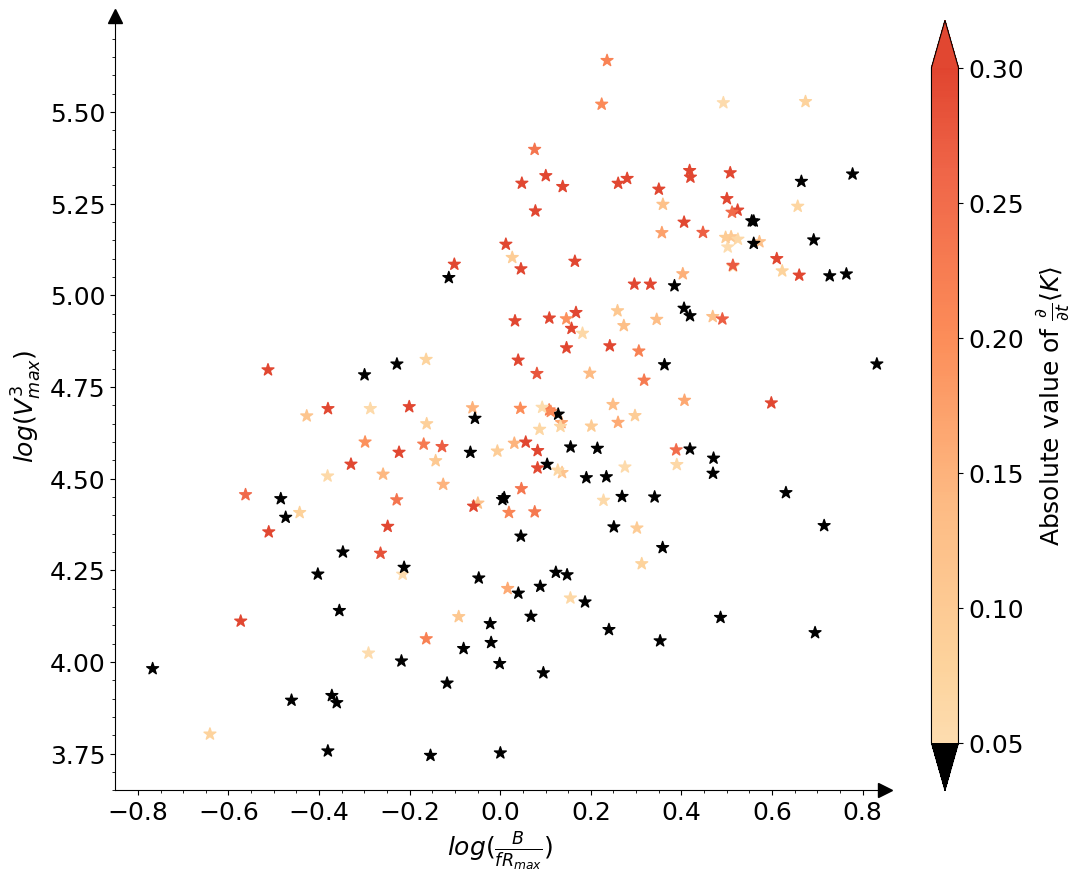

In [293]:
### COLORMAP
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap_ini = cm.get_cmap('OrRd')
cmap     = truncate_colormap(cmap_ini, 0.2, 0.7) # Truncate colormap

### FIGURE
fig, ax  = plt.subplots(figsize=(15, 10))

# Colorbar
c_min = 0.05
c_max = 0.3
cmap.set_under('k')
cmap.set_over(cmap(0.99))

# Plot
sm = ax.scatter(np.log10(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000)), np.log10(dsg.Vmax_1D ** 3), marker='*', s=80, c=abs(dsg.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=1)

# # Regression
# from sklearn.linear_model import LinearRegression
# d_std = dsg.where(abs(dsg.dKdt) < c_min, drop=True)
# X     = np.expand_dims(np.log10(d_std.B_hol / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000)), axis=1)
# y     = np.log10(d_std.Vmax_1D ** 3)
# reg   = LinearRegression().fit(X, y)
# ax.plot([-0.85, 0.85], reg.predict(np.expand_dims(np.array([-0.85, 0.85]), axis=1)), color='k', linestyle='--', label=r'Stationary cases, $R^2 = ${:.2f}'.format(reg.score(X, y)), linewidth=3)
# ax.legend(loc='upper left', frameon=False)

# Grid, legend
ax.minorticks_on()
ax.set_box_aspect(1)
ax.set_ylim(3.65, 5.75);ax.set_xlim(-0.85, 0.85)
ax.set_ylabel(r'$log(V_{max}^3)$')
ax.set_xlabel(r'$log(\frac{B}{f R_{max}})$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
x_ticks = ax.xaxis.get_major_ticks()
x_ticks[-1].label1.set_visible(False)
y_ticks = ax.yaxis.get_major_ticks()
y_ticks[-1].label1.set_visible(False)
# Arrows
ax.plot((1), (3.65), ls="", marker=">", ms=10, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot((-0.85), (1.005), ls="", marker="^", ms=10, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
# Colorbar
cb_ax = fig.add_axes([0.8, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, alpha=1, extend='both', extendfrac=0.07, extendrect=False)
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['save_figs']:
    plt.savefig(PTHS['save_dir'] + 'stationary_crit.pdf', bbox_inches='tight', format='pdf')
    # plt.savefig(PTHS['save_dir'] + 'stationary_crit_wreg.pdf', bbox_inches='tight', format='pdf')

In [258]:
# ### COLORMAP
# def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
#     new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
#         'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
#         cmap(np.linspace(minval, maxval, n)))
#     return new_cmap
# cmap_ini = cm.get_cmap('OrRd')
# cmap     = truncate_colormap(cmap_ini, 0.2, 0.7) # Truncate colormap

# ### FIGURE
# fig, ax  = plt.subplots(figsize=(15, 10))

# # Colorbar
# c_min = 0.05
# c_max = 0.3
# cmap.set_under('k')
# cmap.set_over(cmap(0.99))

# # Plot
# sm = ax.scatter((dsg.B_hol ** 2) / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, marker='*', s=80, c=abs(dsg.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=1)

# # # Regression
# # from sklearn.linear_model import LinearRegression
# # d_std = dsg.where(abs(dsg.dKdt) < c_min, drop=True)
# # X     = np.expand_dims((d_std.B_hol ** 2) / (abs(coriolis(d_std.lat_center)) * d_std.Rmax_1D * 1000), axis=1)
# # y     = d_std.Vmax_1D
# # reg   = LinearRegression().fit(X, y)
# # ax.plot([0, 14], reg.predict(np.expand_dims(np.array([0, 14]), axis=1)), color='k', linestyle='--', label=r'Stationary cases, $R^2 = ${:.2f}'.format(reg.score(X, y)), linewidth=3)
# # ax.legend(loc='upper right', frameon=False)

# # Grid, legend
# ax.minorticks_on()
# ax.set_box_aspect(1)
# ax.set_ylim(15, 80);ax.set_xlim(0, 14)
# ax.set_ylabel(r'$V_{max}$ ($m s^{-1}$)')
# ax.set_xlabel(r'$\frac{B^2}{f R_{max}}$ ($m^{-1} s$)')
# # Ticks and spines
# ax.spines[['right', 'top']].set_visible(False)
# x_ticks = ax.xaxis.get_major_ticks()
# x_ticks[-1].label1.set_visible(False)
# y_ticks = ax.yaxis.get_major_ticks()
# y_ticks[-1].label1.set_visible(False)
# # Arrows
# ax.plot((1.01), (15), ls="", marker=">", ms=10, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
# ax.plot((0), (1.005), ls="", marker="^", ms=10, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
# # Colorbar
# cb_ax = fig.add_axes([0.8, 0.11, 0.018, 0.77])
# cbar  = fig.colorbar(sm, cax=cb_ax, alpha=1, extend='both', extendfrac=0.07, extendrect=False)
# cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $', rotation=90)
# cbar.ax.get_yaxis().labelpad=8

# if PRMS['save_figs']:
#     plt.savefig(PTHS['save_dir'] + 'stationary_crit.pdf', bbox_inches='tight', format='pdf')
#     # plt.savefig(PTHS['save_dir'] + 'stationary_crit_wreg.pdf', bbox_inches='tight', format='pdf')

#### Test by basin

In [179]:
### BASINS

dsg['basin'] = (['time'] , np.array([None for i in range(len(dsg.time))]))
for t in range(len(dsg.time)):
    dsg['basin'][t] = dsg.isel(time=t).storm_id.item().item()[:2]
bss, cts = np.unique(dsg.basin, return_counts=True)
for k in range(len(bss)):
    print('{}, # = {}'.format(bss[k], cts[k]))
    
# Atlantic
da = dsg.where(dsg.basin == 'al', drop=True)
# Pacific
pacific = dsg.basin.isin(['ep', 'cp', 'wp'])
dp      = dsg.where(pacific, drop=True)
# Southern
ds = dsg.where(dsg.basin == 'sh', drop=True)

al, # = 30
cp, # = 6
ep, # = 74
io, # = 4
sh, # = 35
wp, # = 42


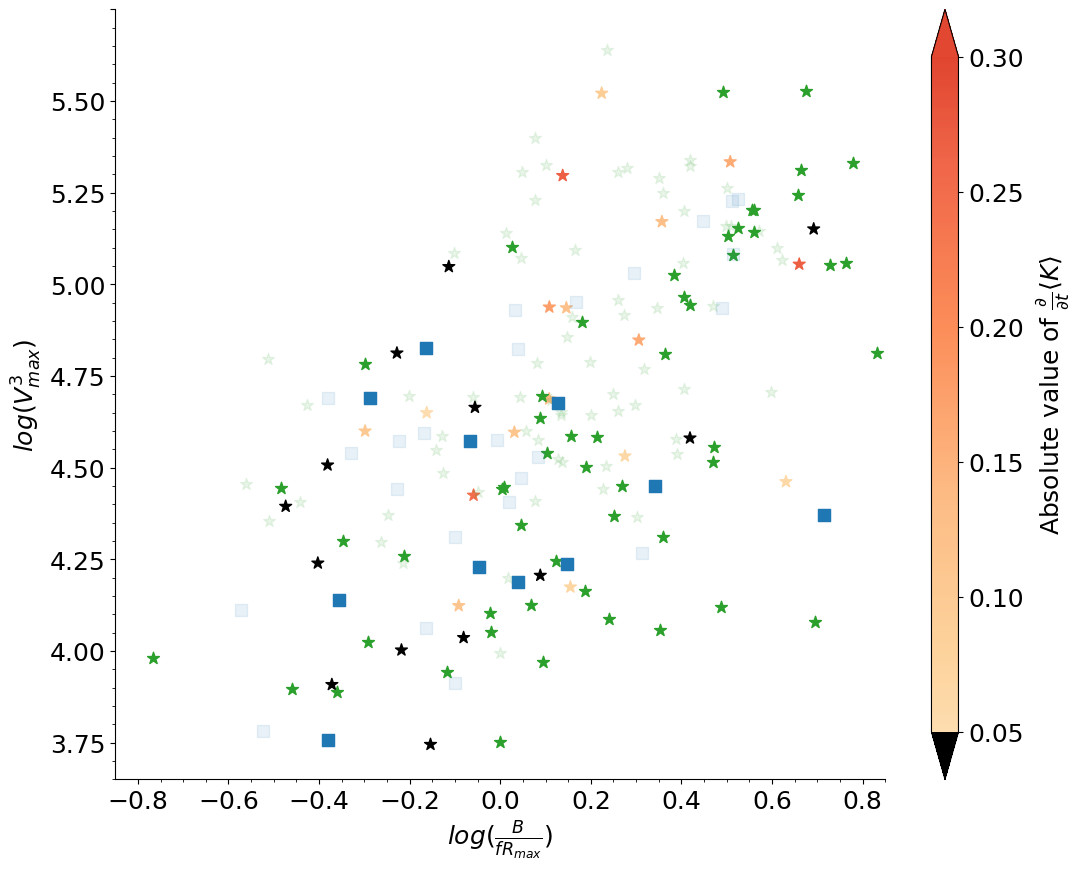

In [291]:
### COLORMAP
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
cmap_ini = cm.get_cmap('OrRd')
cmap     = truncate_colormap(cmap_ini, 0.2, 0.7) # Truncate colormap

### FIGURE
fig, ax  = plt.subplots(figsize=(15, 10))

# Colorbar
c_min = 0.05
c_max = 0.3
cmap.set_under('k')
cmap.set_over(cmap(0.99))

# Plot
# North Atlantic
sm = ax.scatter(np.log10(da.B_hol / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000)), np.log10(da.Vmax_1D ** 3), marker='*', s=80, c=abs(da.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=1)
# Pacific
dp_std = dp.where(abs(dp.dKdt) < c_min, drop=True)
ax.scatter(np.log10(dp.B_hol / (abs(coriolis(dp.lat_center)) * dp.Rmax_1D * 1000)), np.log10(dp.Vmax_1D ** 3), marker='*', s=80, color='tab:green', alpha=0.1)
ax.scatter(np.log10(dp_std.B_hol / (abs(coriolis(dp_std.lat_center)) * dp_std.Rmax_1D * 1000)), np.log10(dp_std.Vmax_1D ** 3), marker='*', s=80, color='tab:green')
# Southern Hemisphere
ds_std = ds.where(abs(ds.dKdt) < c_min, drop=True)
ax.scatter(np.log10(ds.B_hol / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000)), np.log10(ds.Vmax_1D ** 3), marker='s', s=80, color='tab:blue', alpha=0.1)
ax.scatter(np.log10(ds_std.B_hol / (abs(coriolis(ds_std.lat_center)) * ds_std.Rmax_1D * 1000)), np.log10(ds_std.Vmax_1D ** 3), marker='s', s=80, color='tab:blue')

# Grid, legend
ax.minorticks_on()
ax.set_box_aspect(1)
ax.set_ylim(3.65, 5.75);ax.set_xlim(-0.85, 0.85)
ax.set_ylabel(r'$log(V_{max}^3)$')
ax.set_xlabel(r'$log(\frac{B}{f R_{max}})$')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
x_ticks = ax.xaxis.get_major_ticks()
x_ticks[-1].label1.set_visible(False)
y_ticks = ax.yaxis.get_major_ticks()
y_ticks[-1].label1.set_visible(False)
# # Arrows
# ax.plot((1), (3.65), ls="", marker=">", ms=10, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
# ax.plot((-0.85), (1.005), ls="", marker="^", ms=10, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
# Colorbar
cb_ax = fig.add_axes([0.8, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, alpha=1, extend='both', extendfrac=0.07, extendrect=False)
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $', rotation=90)
cbar.ax.get_yaxis().labelpad=8

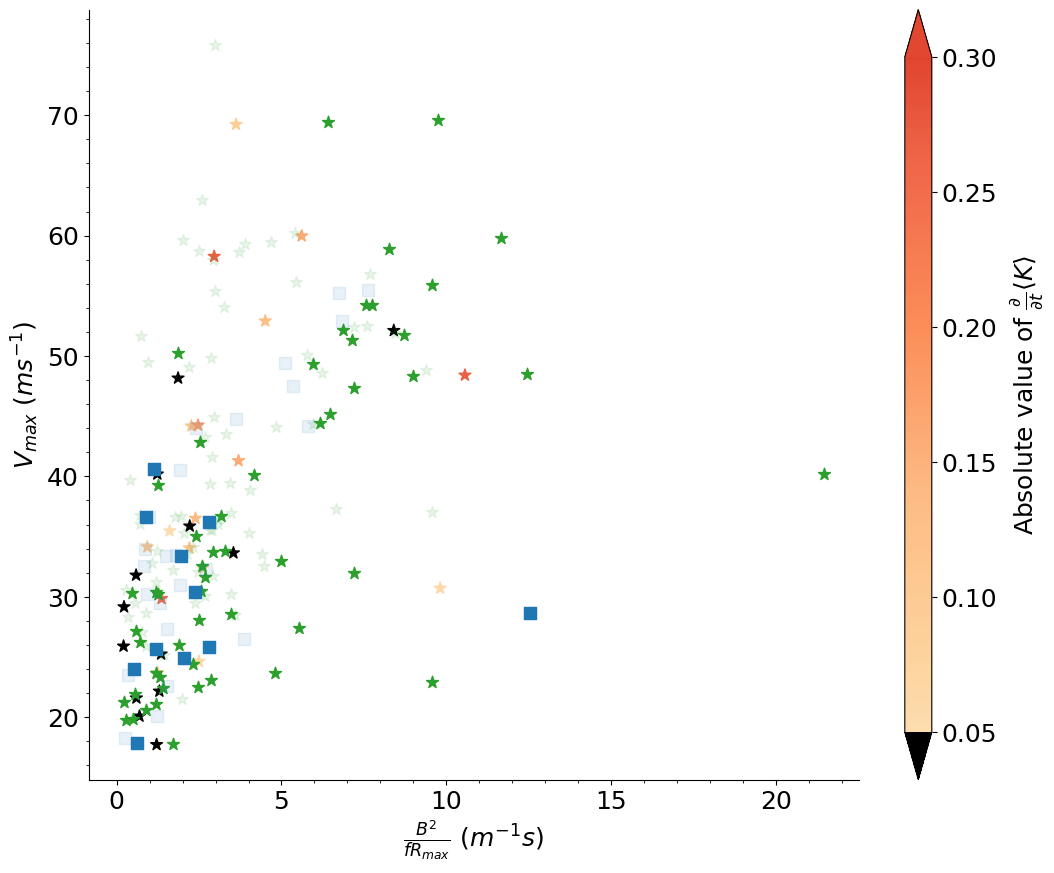

In [206]:
### FIGURE
fig, ax  = plt.subplots(figsize=(15, 10))

# Colorbar
c_min = 0.05
c_max = 0.3
cmap.set_under('k')
cmap.set_over(cmap(0.99))

# Plot
sm = ax.scatter((da.B_hol ** 2) / (abs(coriolis(da.lat_center)) * da.Rmax_1D * 1000), da.Vmax_1D, marker='*', s=80, c=abs(da.dKdt), vmin=c_min, vmax=c_max, cmap=cmap, alpha=1)
dp_std = dp.where(abs(dp.dKdt) < c_min, drop=True)
ax.scatter((dp.B_hol ** 2) / (abs(coriolis(dp.lat_center)) * dp.Rmax_1D * 1000), dp.Vmax_1D, marker='*', s=80, color='tab:green', alpha=0.1)
ax.scatter((dp_std.B_hol ** 2) / (abs(coriolis(dp_std.lat_center)) * dp_std.Rmax_1D * 1000), dp_std.Vmax_1D, marker='*', s=80, color='tab:green')
ds_std = ds.where(abs(ds.dKdt) < c_min, drop=True)
ax.scatter((ds.B_hol ** 2) / (abs(coriolis(ds.lat_center)) * ds.Rmax_1D * 1000), ds.Vmax_1D, marker='s', s=80, color='tab:blue', alpha=0.1)
ax.scatter((ds_std.B_hol ** 2) / (abs(coriolis(ds_std.lat_center)) * ds_std.Rmax_1D * 1000), ds_std.Vmax_1D, marker='s', s=80, color='tab:blue')

# Grid, legend
ax.minorticks_on()
ax.set_box_aspect(1)
# ax.set_ylim(15, 80);ax.set_xlim(0, 14)
ax.set_ylabel(r'$V_{max}$ ($m s^{-1}$)')
ax.set_xlabel(r'$\frac{B^2}{f R_{max}}$ ($m^{-1} s$)')
# Ticks and spines
ax.spines[['right', 'top']].set_visible(False)
x_ticks = ax.xaxis.get_major_ticks()
x_ticks[-1].label1.set_visible(False)
y_ticks = ax.yaxis.get_major_ticks()
y_ticks[-1].label1.set_visible(False)
# Arrows
# ax.plot((1.01), (15), ls="", marker=">", ms=10, color="k", transform=ax.get_yaxis_transform(), clip_on=False)
# ax.plot((0), (1.005), ls="", marker="^", ms=10, color="k", transform=ax.get_xaxis_transform(), clip_on=False)
# Colorbar
cb_ax = fig.add_axes([0.8, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, alpha=1, extend='both', extendfrac=0.07, extendrect=False)
cbar.set_label(r'Absolute value of $\frac{\partial}{\partial t} \langle K \rangle $', rotation=90)
cbar.ax.get_yaxis().labelpad=8


In [ ]:
plt.hist(np.log10(abs(dsg.dKdt_SAR)), bins=100)
print('20% quantile = {:.1f}'.format(np.log10(abs(dsg.dKdt_SAR)).quantile(q=0.2)))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR)) < 14.5) & (np.log10(abs(dsg.dKdt_SAR)) > 13), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR)) > 13, drop=True)

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR)), vmin=14.5, vmax=16, cmap=cmap, marker='*', s=80)

plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR)) < 14.5) & (np.log10(abs(dsg.dKdt_SAR)) > 13), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR)) > 13, drop=True)

plt.scatter(np.sqrt(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000)), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR)), vmin=14.5, vmax=16, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.02, 1)
# plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(np.sqrt(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000)), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) < 9.5) & (np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) > 8.5), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) > 8.5, drop=True)

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR / (d_all.R17_1D * 1000))), vmin=8.5, vmax=11, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
plt.hist(np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) < 4.5) & (np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) > 3.5), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) > 3.5, drop=True)

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))), vmin=3.5, vmax=5.5, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) < 9.5) & (np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) > 8.5), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR / (dsg.R17_1D * 1000))) > 10, drop=True)

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c='tab:red', marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

# cbar    = plt.colorbar()
# cbar.set_label('log(abs(d<K>/dt))', rotation=90)
# cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d2.B_hol / np.sqrt((abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000)), d2.Vmax_1D ** -2.5, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 3);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where(abs(dsg.Vmax_dot_smth_IBT) < 0.2, drop=True)
d_all    = dsg

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=abs(dsg.Vmax_dot_smth_IBT), vmin=0.2, vmax=1, cmap=cmap, marker='*', s=80)

plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20


plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log(abs(dsg.dKdt_SAR)) < 34.6) & (np.log(abs(dsg.dKdt_SAR)) > 33), drop=True)
d_all    = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=np.log(abs(d_all.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
fig, ax  = plt.subplots(figsize=(15, 10))

cmap     = cm.get_cmap('Spectral_r')

# d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR)) < 14.6) & (np.log10(abs(dsg.dKdt_SAR)) > 14), drop=True)
# d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR)) > 14, drop=True)
# d_steady = dsg.where(np.log10(abs(dsg.dKdt_SAR)) < 14.5, drop=True)

d_all = dsg

plt.scatter(1/ (abs(coriolis(d_all.lat_center)) * d_all.R17_1D * 1000), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR)), vmin=14, vmax=16, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d_steady.B_hol / (abs(coriolis(d_steady.lat_center)) * d_steady.R17_1D * 1000), d_steady.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(1 / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 3);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d_steady = dsg.where((np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) < 4.5) & (np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) > 3.5), drop=True)
d_all    = dsg.where(np.log10(abs(dsg.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))) > 3.5, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d_all.B_hol / (abs(coriolis(d_all.lat_center)) * d_all.Rmax_1D * 1000), d_all.Vmax_1D, c=np.log10(abs(d_all.dKdt_SAR / ((dsg.R17_1D * 1000) ** 2))), vmin=3.5, vmax=5.5, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 3);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(1 / (abs(coriolis(d2.lat_center)) * np.sqrt(d2.Rmax_1D * 1000 * d2.R17_1D * 1000)), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 3);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 3)

# d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)
# d2 = dsg.where(abs(dsg.Vmax_dot_smth_IBT) < 0.1, drop=True)
d2 = dsg

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
# plt.scatter(1 / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)

plt.scatter(1 / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=d2.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 3);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('abs(dVm/dt)', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
### Stationary case
# We require np.log(abs(dsg.dKdt_SAR)) > 33 to remove extreme outliers
# dKdt_IBT doesn't work well..

cmap = cm.get_cmap('Spectral_r')

d = dsg.where((np.log(abs(dsg.dKdt_SAR)) < 34.6) & (np.log(abs(dsg.dKdt_SAR)) > 33), drop=True)

plt.title('Stationary (N = {})'.format(len(d.time)))
plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))
plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)
plt.colorbar()

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d2.B_hol ** 2 / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d.B_hol ** 2 / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

#### Former plots

In [ ]:
### Stationary case
# We require np.log(abs(dsg.dKdt_SAR)) > 33 to remove extreme outliers
# dKdt_IBT doesn't work well..

cmap = cm.get_cmap('Spectral_r')

d = dsg.where((np.log(abs(dsg.dKdt_SAR)) < 34.6) & (np.log(abs(dsg.dKdt_SAR)) > 33), drop=True)

plt.title('Stationary (N = {})'.format(len(d.time)))
plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))
plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 6.2);plt.ylim(15, 80)
plt.colorbar()

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d2.B_hol / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), with R34'.format(len(dsg.time)))
plt.scatter(d2.B_hol / (abs(coriolis(d2.lat_center)) * d2.R17_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.R17_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), with R34 and sqrt(B)'.format(len(dsg.time)))
plt.scatter(np.sqrt(d2.B_hol) / (abs(coriolis(d2.lat_center)) * d2.R17_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f R34');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.02, 1);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(np.sqrt(d.B_hol) / (abs(coriolis(d.lat_center)) * d.R17_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')
d2   = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

d2_Area = d2.Vmax_1D * d2.Rmax_1D * 1000 / (2 * d2.B_hol) + d2.R17_1D * 1000 * d2.Vmax_1D / (2 * d2.B_hol) + d2.Vmin_hol * d2.R17_1D * 1000
d_Area  = d.Vmax_1D * d.Rmax_1D * 1000 / (2 * d.B_hol) + d.R17_1D * 1000 * d.Vmax_1D / (2 * d.B_hol) + d.Vmin_hol * d.R17_1D * 1000

plt.title('All (N = {}), With Vmin'.format(len(dsg.time)))
plt.scatter(1 / abs(coriolis(d2.lat_center)), d2_Area, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(1 / abs(coriolis(d.lat_center)), d_Area, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')
d2   = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

d2_Area = (d2.Vmax_1D - d2.Vmin_hol) * d2.Rmax_1D * 1000 / (2 * d2.B_hol) + d2.R17_1D * 1000 * (d2.Vmax_1D - d2.Vmin_hol) / (2 * d2.B_hol) + d2.Vmin_hol * d2.R17_1D * 1000
d_Area  = (d.Vmax_1D - d.Vmin_hol) * d.Rmax_1D * 1000 / (2 * d.B_hol) + d.R17_1D * 1000 * (d.Vmax_1D - d.Vmin_hol) / (2 * d.B_hol) + d.Vmin_hol * d.R17_1D * 1000

plt.title('All (N = {}), With Vmin'.format(len(dsg.time)))
plt.scatter(1 / abs(coriolis(d2.lat_center)), d2_Area, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(1 / abs(coriolis(d.lat_center)), d_Area, marker='*', s=80, color=cmap(0))

In [ ]:
A1_all    = (d2.Vmax_1D - d2.Vmin_hol) * d2.Rmax_1D * 1000 / (2 * d2.B_hol)
A2_all    = d2.R17_1D * 1000 * (d2.Vmax_1D - d2.Vmin_hol) / (2 * d2.B_hol)
A3_all    = d2.Vmin_hol * d2.R17_1D * 1000

A1_steady = (d.Vmax_1D - d.Vmin_hol) * d.Rmax_1D * 1000 / (2 * d.B_hol)
A2_steady = d.R17_1D * 1000 * (d.Vmax_1D - d.Vmin_hol) / (2 * d.B_hol)
A3_steady = d.Vmin_hol * d.R17_1D * 1000

print('All cases')
print('A1 = {:.1f}, A2 = {:.1f}, A3 = {:.1f}'.format(np.nanmean(A1_all) / 1e5, np.nanmean(A2_all) / 1e5, np.nanmean(A3_all) / 1e5))
print('Steady cases')
print('A1 = {:.1f}, A2 = {:.1f}, A3 = {:.1f}'.format(np.nanmean(A1_steady) / 1e5, np.nanmean(A2_steady) / 1e5, np.nanmean(A3_steady) / 1e5))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')
d2   = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

d2_lft_trm = d2.Vmax_1D + (2 * d2.B_hol * d2.Vmin_hol * d2.R17_1D) / (d2.Rmax_1D + d2.R17_1D)
d2_rgt_trm = 2 * d2.B_hol / (abs(coriolis(d2.lat_center)) * ((d2.Rmax_1D + d2.R17_1D) * 1000)) + d2.Vmin_hol

d_lft_trm = d.Vmax_1D + (2 * d.B_hol * d.Vmin_hol * d.R17_1D) / (d.Rmax_1D + d.R17_1D)
d_rgt_trm = 2 * d.B_hol / (abs(coriolis(d.lat_center)) * ((d.Rmax_1D + d.R17_1D) * 1000)) + d.Vmin_hol


plt.title('All (N = {}), With Vmin'.format(len(dsg.time)))
plt.scatter(d2_rgt_trm, d2_lft_trm, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d_rgt_trm, d_lft_trm, marker='*', s=80, color=cmap(0))

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 7)

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {}), TODO: use log10'.format(len(dsg.time)))
plt.scatter(d2.B_hol / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=d2.R17_dot_smth_IBT, vmin=-4, vmax=4, cmap=cmap, marker='*', s=80)


plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

# plt.scatter(d.B_hol / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color='k')

In [ ]:
# ratio = K1_SAR / K2_SAR
# plt.hist(ratio[np.isfinite(ratio)], bins=100)
# plt.xlim(-10, 10)

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=np.log(abs(dsg.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=dsg.dKdt_SAR / 1e16, vmin=-0.3, vmax=0.3, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

### Test by considering H = Vm^2 constant in time

In [ ]:
dK_dt = (dsg['Vmax_1D'] ** 2) * dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) 
cmap  = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {}), neglect H time variation'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=dK_dt / 1e16, vmin=-0.22, vmax=0.22, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

In [ ]:
dK_dt = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
cmap  = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {}), neglect R34 time variation'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=dK_dt / 1e16, vmin=-0.22, vmax=0.22, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('coolwarm', 5)

plt.title('Non-stationary (N = {})'.format(len(dsg.time)))
plt.scatter(dsg.B_hol / (abs(coriolis(dsg.lat_center)) * dsg.Rmax_1D * 1000), dsg.Vmax_1D, c=abs(dsg.dKdt_SAR / (dsg.R33_1D * 1000 * 33 ** 2)) / 1e8, vmin=0, vmax=1, cmap=cmap)

plt.xlabel('B / f Rm');plt.ylabel('Vm')
plt.grid()

cbar    = plt.colorbar()
cbar.set_label('d<K>/dt', rotation=90)
cbar.ax.get_yaxis().labelpad=20

In [ ]:
d1 = dsg.where(dsg.sat_file == 'rs2--owi-cm-20210421t094352-20210421t094508-00003-F7A21_sw.nc', drop=True).isel(time=0)
d2 = dsg.where(dsg.sat_file == 's1b-ew-owi-cm-20190223t202348-20190223t202552-000003-01C2E0_sw.nc', drop=True).isel(time=0)

In [ ]:
# SAR profiles
ws1 = d1.wind_speed.mean(dim='theta', skipna=True)
st1 = d1.wind_speed.std(dim='theta', skipna=True)
ws2 = d2.wind_speed.mean(dim='theta', skipna=True)
st2 = d2.wind_speed.std(dim='theta', skipna=True)
plt.plot(ws1.rad / 1000, ws1, linewidth=3, label='{} SAR profile, B = {:.1f}'.format(d1.storm_name.item().item(), d1.B_hol), c='tab:red')
plt.fill_between(ws1.rad / 1000, ws1 - st1, ws1 + st1, color='tab:red', alpha=0.3)
plt.plot(ws2.rad / 1000, ws2, linewidth=3, label='{} SAR profile, B = {:.1f}'.format(d2.storm_name.item().item(), d2.B_hol), c='tab:blue')
plt.fill_between(ws2.rad / 1000, ws2 - st2, ws2 + st2, color='tab:blue', alpha=0.3)

plt.xlabel('Distance from TC center (km)')
plt.ylabel('Wind speed (m/s)')
plt.minorticks_on()
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# plt.xlim(0, 150);plt.ylim(7, 50)

plt.legend(loc='upper right', frameon=True)

In [ ]:
# SAR profiles
plt.plot(ws1.rad / 1000, ws1.rad * (ws1 ** 2), linewidth=3, label='{} SAR rV^2, B = {:.1f}'.format(d1.storm_name.item().item(), d1.B_hol), c='tab:red')
plt.plot(ws2.rad / 1000, ws2.rad * (ws2 ** 2), linewidth=3, label='{} SAR rV^2, B = {:.1f}'.format(d2.storm_name.item().item(), d2.B_hol), c='tab:blue')

plt.xlabel('Distance from TC center (km)')
plt.ylabel('Wind speed (m/s)')
plt.minorticks_on()
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# plt.xlim(0, 150);plt.ylim(7, 50)

plt.legend(loc='lower right', frameon=True)

In [ ]:
x     = ((dsg.R17_1D * 1000) ** 3) * ((abs(coriolis(dsg.lat_center))) ** 2) / (4 * 17.5 ** 2)
y     = dsg.Rmax_1D * 1000

x_stt = ((d.R17_1D * 1000) ** 3) * ((abs(coriolis(d.lat_center))) ** 2) / (4 * 17.5 ** 2)
y_stt = d.Rmax_1D * 1000

plt.scatter(np.log(x), np.log(y), label='All')
plt.scatter(np.log(x_stt), np.log(y_stt), label='Stationary')
plt.grid()
plt.legend()

In [ ]:
plt.scatter(-np.log(dsg.Rmax_1D / dsg.R33_1D) * dsg.R33_1D / (dsg.R33_1D - dsg.Rmax_1D), dsg.Vmax_1D ** 2, c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 10))
plt.colorbar()
plt.ylabel('Vm^2')

In [ ]:
plt.scatter(-np.log(dsg.Rmax_1D / dsg.R33_1D) * dsg.R33_1D / (dsg.R33_1D - dsg.Rmax_1D), dsg.Vmax_1D ** 2, c=dsg.B_hol, vmin=1, vmax=2.5, cmap=cm.get_cmap('coolwarm', 10))
plt.colorbar()
plt.ylabel('Vm^2')

In [ ]:
plt.scatter(-np.log(dsg.Rmax_1D / dsg.R33_1D) * dsg.R33_1D / (dsg.R33_1D - dsg.Rmax_1D), (1 / dsg.B_hol) * dsg.Vmax_1D ** 2, c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 5))
plt.colorbar()
plt.ylabel('Vm^2')

In [ ]:
plt.scatter(dsg.Rmax_1D, dsg.Vmax_1D ** 2)

In [ ]:
plt.scatter(-0.75 *  np.log(dsg.Rmax_1D / dsg.R33_1D), 1 - (33 ** 2) / (dsg.Vmax_1D ** 2), c=dsg.Vmax_dot_smth_IBT, vmin=-1, vmax=1, cmap=cm.get_cmap('coolwarm', 5))
plt.colorbar()
plt.ylabel('Vm^2')

In [ ]:
plt.scatter(-0.75 *  np.log(dsg.Rmax_1D / dsg.R33_1D), 1 - (33 ** 2) / (dsg.Vmax_1D ** 2), c=dsg.B_hol, vmin=1, vmax=2.5, cmap=cm.get_cmap('coolwarm', 10))
plt.colorbar()
plt.ylabel('Vm^2')

In [ ]:
# dKdt_IBT doesn't work well..
cmap = cm.get_cmap('Spectral_r')

d2 = dsg.where(np.log(abs(dsg.dKdt_SAR)) > 33, drop=True)

plt.title('All (N = {})'.format(len(dsg.time)))
# plt.scatter(d2.B_hol / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)
plt.scatter(d2.x_rkn / (abs(coriolis(d2.lat_center)) * d2.Rmax_1D * 1000), d2.Vmax_1D, c=np.log(abs(d2.dKdt_SAR)), vmin=33, vmax=38, cmap=cmap, marker='*', s=80)


plt.xlabel('x_Rankine / f Rm');plt.ylabel('Vm')
plt.grid()

# plt.xlim(-0.001, 0.06)
# plt.xlim(-0.2, 6.2);plt.ylim(15, 80)

cbar    = plt.colorbar()
cbar.set_label('log(abs(d<K>/dt))', rotation=90)
cbar.ax.get_yaxis().labelpad=20

plt.scatter(d.x_rkn / (abs(coriolis(d.lat_center)) * d.Rmax_1D * 1000), d.Vmax_1D, marker='*', s=80, color=cmap(0))

In [ ]:
plt.scatter(d2.B_hol, d2.x_rkn, c=d2.cyclone_speed, cmap=cm.get_cmap('coolwarm', 5));plt.colorbar()

In [ ]:
plt.hist(d2.B_hol)

In [ ]:
plt.hist(d2.x_rkn, bins=50)

In [ ]:
plt.hist(d2.where(d2.Vmax_1D > 40, drop=True).x_rkn, bins=50)

In [ ]:
plt.scatter(d2.Vmax_1D, d2.Rmax_1D, c=d2.cyclone_speed, cmap=cm.get_cmap('plasma', 3), vmin=2, vmax=8);plt.colorbar()
plt.xlabel('Vmax');plt.ylabel('Rmax')
plt.title('colored by storm speed')

In [ ]:
d3 = d2.where(d2.cyclone_speed < 6, drop=True)

plt.scatter(d3.Vmax_1D, d3.Rmax_1D, c=d3.x_rkn, cmap=cm.get_cmap('plasma', 4), vmin=0.4, vmax=1.2);plt.colorbar()
plt.xlabel('Vmax');plt.ylabel('Rmax')
plt.title('colored by storm speed')

In [ ]:
d3 = d2.where(d2.cyclone_speed < 6, drop=True)

plt.scatter(d2.Vmax_1D, d2.Rmax_1D, c=d2.x_rkn, cmap=cm.get_cmap('plasma', 4), vmin=0.4, vmax=1.2);plt.colorbar()
plt.xlabel('Vmax');plt.ylabel('Rmax')
plt.title('colored by storm speed')

In [ ]:
plt.scatter(d2.x_rkn, d2.cyclone_speed, color='tab:red')
plt.scatter(d3.x_rkn, d3.cyclone_speed, color='tab:blue')